# Project: Predicting the type of physical activity (eg, walking, climbing stairs) from smartphone triaxial accelerometer data

In this project, we'll attempt to predict the type of physical activity (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data. Smartphone accelerometers are very precise, and different physical activities give rise to different patterns of acceleration.

Importing the neccesary packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from statistics import mean
import time

import warnings
warnings.filterwarnings("ignore")
start_time= time.process_time()

Load the different training .csv files. 
The first file **train_time_series.csv**, contains the raw accelerometer data in the following file formats:
- Timestamp
- UTC time
- Accuracy
- x, y, z
The second file train_labels.csv contains the activity labels, and we'll be using these label to train our model.
Various activities have been labelled as follows:
- 1 => Standing
- 2 => Walking
- 3 => Climbing down the stairs.
- 4 => Climbing up the stairs.

In [2]:
#%% load the different training .csv files
df_train_time = pd.read_csv('train_time_series.csv')
df_train_labels = pd.read_csv('train_labels.csv')
df_train_time

,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z
0,20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
1,20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
2,20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
3,20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
4,20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450
...,...,...,...,...,...,...,...
3739,24325,1565110305638,2019-08-06T16:51:45.638,unknown,0.024384,-0.710709,0.030304
3740,24326,1565110305738,2019-08-06T16:51:45.738,unknown,0.487228,-1.099136,-0.015213
3741,24327,1565110305838,2019-08-06T16:51:45.838,unknown,0.369446,-0.968506,0.036713
3742,24328,1565110305939,2019-08-06T16:51:45.939,unknown,0.167877,-0.802826,0.049805


## Process the information
In this part we process the information. We calculate various engineering signal features.
- magnitude: The Euclidean Norm Minus One (ENMO) with negative values rounded to zero in g has been shown to correlate with the magnitude of acceleration and human energy expenditure.
- alfa, beta: Calculate pitch and roll tilt angle, which produces constant sensitivity over 360° of rotation.
- lids: Locomotor Inactivity During Sleep (LIDS)24 involves a non-linear conversion of locomotor activity and has shown to be sensitive to ultradian sleep cycles.

In [3]:
#%% Pre-Process the training files
df_train_time.rename(columns={'Unnamed: 0': 'code'}, inplace=True)
df_train_labels.rename(columns={'Unnamed: 0': 'code'}, inplace=True)

def calculos_engineer(x, y, z, df_in, df_out, inicio):
    df_in['magnitude'] = np.maximum(0, np.sqrt(np.square(x) + np.square(y) + np.square(z))-1)
    df_in['alfa'] = np.arctan(x / np.sqrt(np.square(y) + np.square(z)))
    df_in['beta'] = np.arctan(y / np.sqrt(np.square(x) + np.square(z)))
    activity_count = np.maximum(0, df_in['magnitude'] -0.02)
    df_in['lids'] = 100 / (activity_count + 1)
    
    x = []
    y = []
    z = []
    magnitude = []
    alfa = []
    beta = []
    lids = []

    for i in range(inicio, len(df_in), 10):
        x.append(df_in.x[i])
        y.append(df_in.y[i])
        z.append(df_in.z[i])
        magnitude.append(df_in.magnitude[i])
        alfa.append(df_in.alfa[i])
        beta.append(df_in.beta[i])
        lids.append(df_in.lids[i])
    
    df = df_out.copy()
    df['x'] = x
    df['y'] = y
    df['z'] = z
    df['magnitude'] = magnitude
    df['alfa'] = alfa
    df['beta'] = beta
    df['lids'] = lids
    
    return df

x_0 = df_train_time.x
y_0 = df_train_time.y
z_0 = df_train_time.z
inicio = 3
df = calculos_engineer(x_0, y_0, z_0, df_train_time, df_train_labels, inicio)

df_train_time.head()

,code,timestamp,UTC time,accuracy,x,y,z,magnitude,alfa,beta,lids
0,20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046,0.000000,-0.006918,-1.496750,100.000000
1,20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554,0.021548,-0.065111,-1.461406,99.845453
2,20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467,0.037644,-0.041922,-1.392834,98.266225
3,20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,0.000000,-0.054287,-1.482452,100.000000
4,20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450,0.012993,-0.053364,-1.434630,100.000000


In [4]:
df.head()

,code,timestamp,UTC time,label,x,y,z,magnitude,alfa,beta,lids
0,20589,1565109931087,2019-08-06T16:45:31.087,1,-0.053802,-0.987701,0.068985,0.000000,-0.054287,-1.482452,100.00000
1,20599,1565109932090,2019-08-06T16:45:32.090,1,0.013718,-0.852371,-0.000870,0.000000,0.016092,-1.554672,100.00000
2,20609,1565109933092,2019-08-06T16:45:33.092,1,0.145584,-1.007843,-0.036819,0.018969,0.143365,-1.422885,100.00000
3,20619,1565109934094,2019-08-06T16:45:34.094,1,-0.099380,-1.209686,0.304489,0.251372,-0.079501,-1.311959,81.21025
4,20629,1565109935097,2019-08-06T16:45:35.097,1,0.082794,-1.001434,-0.025375,0.005171,0.082462,-1.484539,100.00000


### Define all covariates and outcomes

In [5]:
#%% Define all covariates and outcomes from `df_train_labels`.
classification_target = 'label'
all_covariates = [ 
                  'alfa',
                  'beta',
                  'lids',
                  'magnitude',
                  'x',
                  'y',
                  'z',
                  'timestamp'
                  ]

classification_outcome = df[classification_target]
covariates = df[all_covariates]

## Exploratory Data Analysis
### Evaluate the skew of each variable

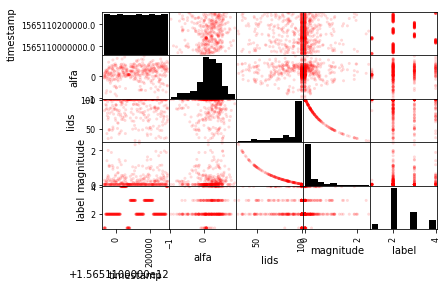

alfa        -0.761679
beta         1.968191
lids        -1.406860
magnitude    2.525214
x            0.294193
y           -1.111177
z            1.319239
timestamp   -0.000429
label        0.601406
dtype: float64


In [6]:
# we will evaluate the skew of each variable.
outcomes_and_covariantes = all_covariates + [classification_target]

plotting_variables = ['timestamp', 'alfa', 'lids', 'magnitude', classification_target]
axes = pd.plotting.scatter_matrix(df[plotting_variables], alpha=0.15, \
       color=(0,0,0), hist_kwds={"color":(0,0,0)}, facecolor=(1,0,0))
plt.show()

print(df[outcomes_and_covariantes].skew())

In [7]:
for covariate in all_covariates:
    df[covariate] = df[covariate].apply(lambda x: np.log10(1+x))

print(df[outcomes_and_covariantes].skew())

alfa        -3.031844
beta        -0.237234
lids        -1.872305
magnitude    1.824255
x           -1.727916
y           -1.542558
z           -0.639096
timestamp    0.000000
label        0.601406
dtype: float64


### Data Visualisation

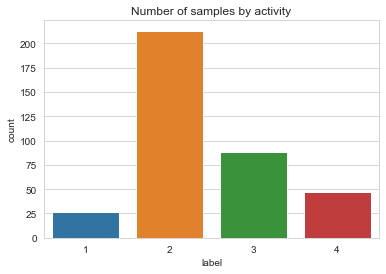

In [8]:
#%% Analyzing class label distribution
sns.set_style('whitegrid')
sns.countplot(x = 'label', data = df)
plt.title('Number of samples by activity')
plt.show()

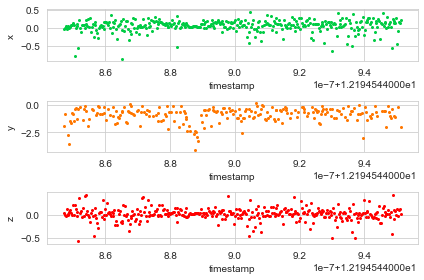

In [9]:
#%% plot the diferents variables
timestamp = df.timestamp
label = df.label
av = df.magnitude
x = df.x
y = df.y
z = df.z

fig, axs = plt.subplots(3)
axs[0].plot(timestamp, x, "o", ms=2, c="#00cc44")
axs[1].plot(timestamp, y, "o", ms=2, c="#ff7700")
axs[2].plot(timestamp, z, "o", ms=2, c="#ff0000")
axs[0].set(xlabel ="timestamp", ylabel="x")
axs[1].set(xlabel ="timestamp", ylabel="y")
axs[2].set(xlabel ="timestamp", ylabel="z")
plt.tight_layout()
plt.show()


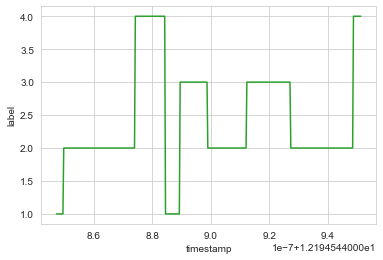

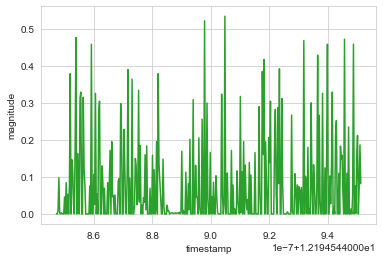

In [10]:
def plot_data(variable1, variable2):
    plt.figure()
    plt.plot(variable1, variable2, 'tab:green')
    plt.xlabel("{}".format(variable1.name))
    plt.ylabel("{}".format(variable2.name))
    plt.show()

plot_data(timestamp, label)
plot_data(timestamp, av)

## Building classification models

### Cross-validated performance for the linear and random forest classification models
we will compute cross-validated performance for the linear and random forest classification models.
Instantiate all regression models and classifiers.

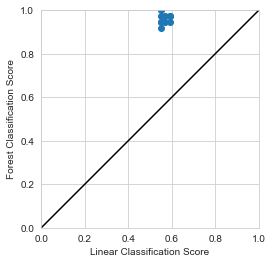

In [11]:
logistic_regression = LogisticRegression()
forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)

def accuracy(estimator, X, y):
    predictions = estimator.fit(X, y).predict(X)
    return accuracy_score(predictions, y)

# Determine the cross-validated accuracy for logistic and random forest models.
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)
# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")

# Show the plot.
plt.show()

According to the graph, the Forest Classification algorithm is chosen instead of the Linear Classification algorithm.

### Imbalanced data
We observed from our data that some labels occur more frequently than others leading to an imbalanced dataset. Such data needs to be handled with care when used with machine learning models since the model might learn to always predict the class with the majority of samples.For this reason we use the SMOTE technique.

In [12]:
#%%Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(covariates, classification_outcome)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.2, stratify=over_y)

### Build a Random Forest Classifier SMOTE SRF model

In [13]:
#%% Build a Random Forest Classifier SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0)

#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=0)
#Evaluate SMOTE SRF model
scoring = ('precision_macro', 'recall_macro')
scores = cross_validate(SMOTE_SRF, over_X, over_y, cv=cv, scoring=scoring, return_train_score=True)
print(scores.keys())
print(scores)
print('Test Precision: %.3f' % mean(scores['test_precision_macro']))

dict_keys(['fit_time', 'score_time', 'test_precision_macro', 'train_precision_macro', 'test_recall_macro', 'train_recall_macro'])
{'fit_time': array([0.20776081, 0.28152442, 0.2043345 , 0.20744514, 0.1953311 ,
       0.19681573, 0.26690912, 0.24393725, 0.19607449, 0.19070911,
       0.23184228, 0.21888137]), 'score_time': array([0.02026463, 0.02377319, 0.01595592, 0.02349854, 0.01595688,
       0.0148747 , 0.02293849, 0.01595759, 0.0159564 , 0.01695561,
       0.01795292, 0.01657581]), 'test_precision_macro': array([0.80734037, 0.79464047, 0.83323397, 0.78474982, 0.79220474,
       0.77108516, 0.77275428, 0.80424315, 0.8249887 , 0.78382353,
       0.80482804, 0.72853972]), 'train_precision_macro': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'test_recall_macro': array([0.81149546, 0.79411251, 0.82555905, 0.78913347, 0.79245283,
       0.76624738, 0.77428372, 0.80328442, 0.82573375, 0.78467855,
       0.8024109 , 0.72344514]), 'train_recall_macro': array([1., 1., 1., 1., 1.,

In [14]:
#%% Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(covariates, classification_outcome, test_size=0.2, stratify=classification_outcome)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

SMOTE_SRF.fit(over_X_train, over_y_train)

# Predict
preds = SMOTE_SRF.predict(X_test)

# Check the Accuracy of the Model
# Check the accuracy of the model, we will check how the predictions stack up against the actual test set values.
print(pd.crosstab(y_test, preds, rownames=['Actual Result'], colnames=['Predicted Result']))

(300, 8) (300,)
(75, 8) (75,)
Predicted Result  1   2   3  4
Actual Result                 
1                 5   0   0  0
2                 0  41   1  1
3                 0   0  18  0
4                 0   0   0  9


### Model accuracy

In [15]:
print(accuracy_score(y_test, preds))

0.9733333333333334


In [16]:
#%% Check Feature Importance
print(sorted(list(zip(covariates, SMOTE_SRF.feature_importances_)), key=lambda tup: tup[1]))

[('lids', 0.0867596391478782), ('magnitude', 0.10493046550631903), ('x', 0.1102738602947862), ('alfa', 0.11662557236462821), ('z', 0.12026108845532885), ('y', 0.14695675238940661), ('beta', 0.15455685307208245), ('timestamp', 0.1596357687695705)]


## Activity Classification
To test the encoding we use the test_time_series.csv file. The results of the predictions are stored in a column called 'label' in the data frame called 'df_test_labels'. The final results of the prediction are saved in a file called 'predictions.csv', which corresponds to the file 'test_labels.csv' but with the column 'label' of the final results.

In [17]:
#%%  load the different test .csv files
df_test_time = pd.read_csv('test_time_series.csv')
df_test_labels = pd.read_csv('test_labels.csv')

df_test_time.rename(columns={'Unnamed: 0': 'code'}, inplace=True)
df_test_labels.rename(columns={'Unnamed: 0': 'code'}, inplace=True)
print(df_test_time.head())
print(df_test_labels.head())

x_1 = df_test_time.x
y_1 = df_test_time.y
z_1 = df_test_time.z
inicio = 9
df_test = calculos_engineer(x_1, y_1, z_1, df_test_time, df_test_labels, inicio)
X_predictors = df_test[all_covariates]
predictions=SMOTE_SRF.predict(X_predictors)

# add to the data frame df_test_labels
df_test_labels['label'] = predictions
df_test_labels.to_csv('predictions.csv')

    code      timestamp                 UTC time accuracy         x         y  \
0  24330  1565110306139  2019-08-06T16:51:46.139  unknown  0.034286 -1.504456   
1  24331  1565110306239  2019-08-06T16:51:46.239  unknown  0.409164 -1.038544   
2  24332  1565110306340  2019-08-06T16:51:46.340  unknown -0.234390 -0.984558   
3  24333  1565110306440  2019-08-06T16:51:46.440  unknown  0.251114 -0.787003   
4  24334  1565110306540  2019-08-06T16:51:46.540  unknown  0.109924 -0.169510   

          z  
0  0.157623  
1  0.030975  
2  0.124771  
3  0.054810  
4  0.235550  
    code      timestamp                 UTC time  label
0  24339  1565110307041  2019-08-06T16:51:47.041    NaN
1  24349  1565110308043  2019-08-06T16:51:48.043    NaN
2  24359  1565110309046  2019-08-06T16:51:49.046    NaN
3  24369  1565110310048  2019-08-06T16:51:50.048    NaN
4  24379  1565110311050  2019-08-06T16:51:51.050    NaN


We create a confusion matrix.

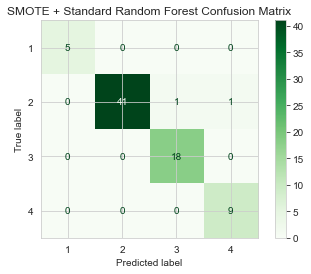

In [18]:
#%% Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=['1', '2', '3', '4'], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()

### Code Run Time

In [19]:
#%% Code Run Time
end_time=time.process_time() 
elapsed_time=end_time - start_time 
print(elapsed_time)

8.515625
